# Point Estimation from Process Tomography Data #

## Preamble ##

We begin by setting Python 2/3 compatability options and configuring Jupyter Notebook to show plots.

In [1]:
from __future__ import division, print_function
%matplotlib inline

We then import NumPy and QuTiP to represent data.

In [2]:
import numpy as np
from scipy.io import loadmat, savemat
import scipy.sparse
import qutip as qt
qt.settings.colorblind_safe = True

We next import and configure plotting support.

In [3]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from mpltools.special import hinton

try: plt.style.use('ggplot')
except: pass

Since we'll be using convex optimization to find point estimates, we also need to import PICOS. We also import CVXOPT to make it easier to define constants as CVXOPT matrices.

In [4]:
import picos
import cvxopt

Finally, we import some useful functions for functional programming and for working with iterators.

In [5]:
from toolz import compose, memoize
from operator import mul
from functools import partial, reduce
from itertools import product, starmap

## Version Table ##

In [6]:
import sys
import scipy
import toolz
import matplotlib as mpl

print("\n".join(map("{0[0]}: {0[1]}".format, [
    ("Python", sys.version),
    ('QuTiP', qt.__version__),
    ('PICOS', picos.__version__),
    ('CVXOPT', '1.1.8'),
    ('NumPy', np.__version__),
    ('SciPy', scipy.__version__),
    ('Matplotlib', mpl.__version__),
    ('Toolz', toolz.__version__)
])))

Python: 3.5.2 |Anaconda custom (64-bit)| (default, Jul  2 2016, 17:53:06) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
QuTiP: 4.0.0.dev0+9262cae
PICOS: 1.1.3.dev
CVXOPT: 1.1.8
NumPy: 1.11.3
SciPy: 0.18.1
Matplotlib: 1.5.3
Toolz: 0.8.2


$$
    % We also define new LaTeX commands...
    \newcommand{\Tr}{\operatorname{Tr}}
    \newcommand{\TT}{\mathrm{T}}
    \newcommand{\id}{\mathbb{1}}
    \newcommand{\sket}[1]{|#1\rangle\!\rangle}
    \newcommand{\sbra}[1]{\langle\!\langle#1|}
    \newcommand{\defeq}{\mathrel{:=}}
$$

## Theory ##

Adopting the column-stacking convention for the Choi-Jamiłokowski isomorphism, we have the useful identity that
$$\begin{aligned}
    \Tr(E \Lambda[\rho]) &= \Tr\left[(\rho^{\TT} \otimes E) J(\Lambda)\right],
\end{aligned}$$
where $J(\Lambda) = (\id \otimes \Lambda)[\sket{\id}\sbra{\id}]$ is the Choi operator for the channel $\Lambda$, $E$ is a measurement effect, and $\rho$ is a preparation. Using this, we can represent all process tomography experiments as state tomography with the *effective* measurement effects given by $E' = \rho^{\TT} \otimes E$.

*NB: this identity looks different in other conventions such as row-stacking.*

In this Notebook, we will utilize this representation almost militantly to make it easier to represent process tomography in a convex optimization context.

## Data Representation ##

As per ``README.txt``, the raw data is formatted as:

<table>
    <tr>
        <th>Prep./Meas. Operator Index</th>
        <th>Population $DD$</th>
        <th>Population $DS$</th>
        <th>Population $SD$</th>
        <th>Population $SS$</th>
    </tr>
</table>

where $\left|D\right\rangle = \left|0\right\rangle$ and $\left|S\right\rangle = \left|1\right\rangle$.

Here, the preparation and measurement index is an integer in ``range(144)`` describing the preparation from the input states $\{S,+,-,D\}\times\{S,+,-,D\}$ and the measurement bases $\{ZZ,YZ,XZ,\dots,XX\}$:

<table>
    <tr>
        <th>Index</th>
        <th>Preparation</th>
        <th>Measurement Basis</th>
    </tr>
    
    <tr>
        <td>0</td>
        <td>$\left|SS\right\rangle$</td>
        <td>$ZZ$</td>
    </tr>
    
    <tr>
        <td>1</td>
        <td>$\left|SS\right\rangle$</td>
        <td>$YZ$</td>
    </tr>
    
    <tr>
        <td></td>
        <td>$\vdots$</td>
        <td></td>
    </tr>
</table>

Following the above theory, we then have that each *row* (slice along its leftmost index) describes an *effective* (that is, includes the preparation) POVM $\mathcal{E}'_i$ with effects labeled by the columns $E'_{i,j}$. We thus start by defining the basis for the *bare* measurement effects $E$, excluding state preparations. We do so in terms of labels, so that we can map those labels to indices later. This is not strictly necessary, but makes it much easier to debug.

In [7]:
single_qubit_measurement_bases = {
    'Z': [qt.basis(2, 1), qt.basis(2, 0)],
    'Y': [qt.Qobj([[1], [-1j]]).unit(), qt.Qobj([[1], [1j]]).unit()],
    'X': [qt.Qobj([[1], [-1]]).unit(), qt.Qobj([[1], [1]]).unit()]
}

In [8]:
measurement_bases = {
    (P, Q): list(starmap(qt.tensor, product(P_basis, Q_basis)))
    for (P, P_basis), (Q, Q_basis)
    in product(single_qubit_measurement_bases.items(), repeat=2)
}

Next, we define input states corresponding to the symbols ``{S, +, -, D}``.

In [9]:
single_qubit_input_states = {
    'S': qt.basis(2, 0),
    '+': qt.Qobj([[1], [1]]).unit(),
    '-': qt.Qobj([[1], [1j]]).unit(),
    'D': qt.basis(2, 1)
}

In [10]:
input_states = {
    (left, right): qt.tensor(psi_left, psi_right)
    for (left, psi_left), (right, psi_right)
    in product(single_qubit_input_states.items(), repeat=2)
}

We can now define which labels correspond to which indices by making lists of labels for each of the preparation and the measurement bases, then taking the Cartesian product to obtain the final mapping from labels to "rows."

In [11]:
measurement_basis_labels = list(product('ZYX', repeat=2))
print("{{{}}}".format(", ".join(map("".join, measurement_basis_labels))))

{ZZ, ZY, ZX, YZ, YY, YX, XZ, XY, XX}


In [12]:
preparation_labels = list(map(compose(tuple, reversed), product('S+-D', repeat=2)))
print("{{{}}}".format(", ".join(map("".join, preparation_labels))))

{SS, +S, -S, DS, S+, ++, -+, D+, S-, +-, --, D-, SD, +D, -D, DD}


We now compute the product over preparation and measurement labels.

In [13]:
effective_povm_labels = [
    (prep, meas_basis)
    for prep, meas_basis
    in product(
        preparation_labels,
        measurement_basis_labels
    )
]

In [14]:
nest = partial(partial, map)
map(compose(print, nest("".join)), effective_povm_labels[:16]);

We're almost there. We can now build a list of effective POVMs to identify the "rows". The final measurement effect table we can quickly obtain by identifying the "column" (rightmost) index as the index into each POVM. 

In [15]:
effective_povms = np.array([
    [
        qt.tensor(
            qt.ket2dm(input_states[prep_label]).trans(),
            qt.ket2dm(bare_effect)
        ).data.todense()
        for bare_effect in measurement_bases[meas_basis_label]
    ]
    for prep_label, meas_basis_label in effective_povm_labels
])

Each entry in the table now specifies a term in the sum that is the objective function
$$
    \hat{\Lambda}_{\text{sdp}} = \arg\,\min \left\|
        \sum_{ij} \operatorname{Tr}(M_{ij} J(\Lambda)) - D_{ij}
    \right\|^2_2.
$$

To find the matching $D$ array, we need to load the data. We'll start with the example of the ``0_ms.txt`` data, which represents process tomography in which the initial state is prepared, then immediately measured (that is, after $t = 0\text{ ms}$ wait time).

In [16]:
population_data = loadmat('innsbruck-data.mat')['0_ms.txt']

As a quick check, let's plot a few "rows" of the data and compare to our labels, make sure that things make sense and match our conventions.

In [17]:
for idx, ((prep_label, meas_label), populations) in enumerate(list(zip(effective_povm_labels, population_data))[:4 * 9]):
    if idx % 9 == 0:
        print("=" * 48)
    print(
        u"ρ {}, E {} || DD {:.2f}, DS {:.2f}, SD {:.2f}, SS {:.2f}".format(
            "".join(prep_label),
            "".join(meas_label),
            *populations
        )
    )
print("=" * 48)

ρ SS, E ZZ || DD 0.00, DS 0.00, SD 0.01, SS 0.99
ρ SS, E ZY || DD 0.01, DS 0.01, SD 0.49, SS 0.49
ρ SS, E ZX || DD 0.00, DS 0.00, SD 0.46, SS 0.54
ρ SS, E YZ || DD 0.00, DS 0.59, SD 0.00, SS 0.41
ρ SS, E YY || DD 0.28, DS 0.21, SD 0.25, SS 0.26
ρ SS, E YX || DD 0.22, DS 0.26, SD 0.24, SS 0.28
ρ SS, E XZ || DD 0.00, DS 0.45, SD 0.00, SS 0.55
ρ SS, E XY || DD 0.21, DS 0.29, SD 0.22, SS 0.28
ρ SS, E XX || DD 0.25, DS 0.25, SD 0.25, SS 0.25
ρ +S, E ZZ || DD 0.00, DS 0.47, SD 0.00, SS 0.53
ρ +S, E ZY || DD 0.22, DS 0.31, SD 0.23, SS 0.24
ρ +S, E ZX || DD 0.29, DS 0.27, SD 0.17, SS 0.27
ρ +S, E YZ || DD 0.00, DS 0.47, SD 0.00, SS 0.53
ρ +S, E YY || DD 0.27, DS 0.17, SD 0.33, SS 0.24
ρ +S, E YX || DD 0.25, DS 0.24, SD 0.26, SS 0.25
ρ +S, E XZ || DD 0.00, DS 0.02, SD 0.00, SS 0.98
ρ +S, E XY || DD 0.01, DS 0.02, SD 0.50, SS 0.47
ρ +S, E XX || DD 0.01, DS 0.04, SD 0.44, SS 0.51
ρ -S, E ZZ || DD 0.01, DS 0.54, SD 0.00, SS 0.45
ρ -S, E ZY || DD 0.28, DS 0.33, SD 0.21, SS 0.18
ρ -S, E ZX || DD 0.2

## Convex Optimization ##

We can now use PICOS to define the tomography problem
$$\begin{aligned}
    J(\hat{\Lambda}) = & \operatorname{arg\,min}_{J(\Lambda)} \| \vec{\Delta} \|_2 \\
                       & \text{s. t. } J(\Lambda) \succ 0, \\ 
                       & \hphantom{\text{s. t. }} \Tr_2(J(\Lambda)) = \id, \\
                       & \text{where } \vec{\Delta} \defeq \vec{F} - \vec{D}, \\
                       & \hphantom{\text{where }} F_{(i, j)} \defeq \Tr([\rho_i^{\TT} \otimes E_j] J(\Lambda)) \\ 
                       & \hphantom{\text{where }} D_{(i, j)} \defeq \text{datum in row } i \text{ and column } j, \\
                       & \hphantom{\text{where }} (i, j) \defeq 144 i + j.
\end{aligned}$$
As an annoying implementation detail, we represent this problem by introducing a slack variable $t$ and report the arg min of $t$ subject to $\|\vec{\Delta}\|_2 \le t$. In any case, the solution to this problem is the least-squares solution to the process tomography problem, subject to the positive semidefinite and trace preserving constraints.

In [18]:
def solve_tomography_problem(population_data, norm=2, solve_options=None, quiet=False):
    # Set a few options for the PICOS solver.
    solve_options = {'maxit': 40} if solve_options is None else solve_options
    if quiet:
        solve_options['verbose'] = 0
    
    # Define the PICOS representation of the tomography problem above.
    tomography_problem = picos.Problem()
    
    # Define the parameters.
    data_matrix = cvxopt.matrix(population_data.astype('float64').flatten(order='C'))
    
    # Define the variables for the new problem.
    J = tomography_problem.add_variable("J", (16, 16), "hermitian")
    model_matrix = tomography_problem.add_variable("F", (np.prod(data_matrix.size), ), "continuous")
    
    # Define a bit of useful shorthand.
    delta = data_matrix - model_matrix
    
    # Set the objective function, using a constraint on a new slack variable.
    t = tomography_problem.add_variable('t', 1, 'continuous')
    tomography_problem.add_constraint(
        picos.norm(delta, norm) < t
    )
    tomography_problem.set_objective('min',
        t
    )
    
    # We then finish defining the problem by adding three constraints.
    # First, we need the model matrix F to agree with J, since all of the
    # objective functions are on F and not J directly.
    tomography_problem.add_list_of_constraints([
        (
            picos.trace(cvxopt.matrix(effective_povms[idx_prepmeas, idx_basis_element]) * J)
        ).real == model_matrix[idx_constraint]
        # This indexing specification is *row-major* (C).
        for idx_constraint, (idx_prepmeas, idx_basis_element) in enumerate(product(*map(range, population_data.shape)))
    ])
    # We can now constrain J itself to be PSD and TP.
    tomography_problem.add_constraint(J >> 0.0)
    tomography_problem.add_constraint(picos.partial_trace(J, k=1, dim=(4, 4)) == cvxopt.matrix(np.eye(4)))
    
    # Next, actually solve the problem.
    tomography_problem.solve(**solve_options)
    J_qobj = qt.Qobj(np.array(J.value), superrep='choi', dims=[[[2, 2], [2, 2]], [[2, 2], [2, 2]]])
    
    # [Optional] Print out diagnostics.
    if not quiet:
        print("""
Mean residual in Δ:\t{:.2%}
Purity of J(Λ) / D:\t{:.2%}
AGF F(Λ):\t\t{:.2%}
Unitarity u(Λ):\t{:.2%}
            """.strip().format(
                np.abs(delta.value).mean(),
                (J_qobj.unit() ** 2).tr(),
                qt.average_gate_fidelity(J_qobj),
                qt.unitarity(J_qobj)
            )
        )
    
    # Unpack and return J.
    return J_qobj

Having now defined the tomography problem, we solve for $J$ using the ``0_ms.txt`` dataset and report the least-squares estimate (2-norm).

In [19]:
J_qobj = solve_tomography_problem(population_data, norm=2, solve_options=dict(maxit=80))

*** Making the problem real...  ***
*** OK, solve the real problem and transform the solution as in the original problem...  ***
*** Dualizing the problem...  ***
--------------------------
  cvxopt CONELP solver
--------------------------
     pcost       dcost       gap    pres   dres   k/t
 0:  1.4856e-01  2.7229e-01  2e+02  6e+00  3e+00  1e+00
 1: -1.6587e+00 -1.9050e+00  2e+01  4e+00  9e-01  2e-01
 2: -1.0066e+00 -1.1751e+00  6e+00  2e+00  3e-01  9e-03
 3: -7.1446e-01 -1.2100e+00  3e+00  4e+00  2e-01  5e-03
 4: -5.6512e-01 -9.4638e-01  3e+00  3e+00  2e-01  4e-03
 5: -1.2124e+00 -9.7295e-01  2e+00  5e+00  1e-01  3e-03
 6: -9.2182e-01 -8.0256e-01  8e-01  5e+00  8e-02  1e-03
 7: -7.3111e-01 -6.6900e-01  4e-01  2e+00  3e-02  4e-04
 8: -7.3230e-01 -6.8893e-01  2e-01  2e+00  2e-02  3e-04
 9: -7.2268e-01 -6.9257e-01  1e-01  2e+00  1e-02  2e-04
10: -7.1377e-01 -6.9332e-01  6e-02  1e+00  6e-03  1e-04
11: -7.0776e-01 -6.9435e-01  3e-02  1e+00  3e-03  7e-05
12: -7.0989e-01 -6.9560e-01  3e-02

### Solution Diagnostics ###

Once we have a solution, we can look at its properties to check that it behaves as we expect.

We start by extracting the solution as a QuTiP superoperator in the Choi and super representations.

In [20]:
S_qobj = qt.to_super(J_qobj)

In [21]:
np.linalg.eigvals(np.diag(qt.to_chi(S_qobj).unit().data.todense()).reshape((4, 4)).copy())

array([  9.36723302e-01+0.j,   4.83177263e-03+0.j,  -1.01539019e-04+0.j,
         1.28009670e-03+0.j])

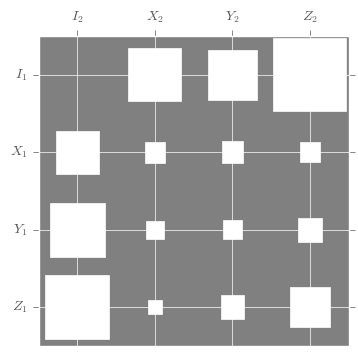

In [22]:
plt_data = np.diag(qt.to_chi(S_qobj).unit().data.todense()).reshape((4, 4)).copy()
plt_data[0, 0] = 0
hinton(plt_data)
plt.xticks(np.arange(4), map(r"${}_2$".format, "IXYZ"))
plt.yticks(np.arange(4), map(r"${}_1$".format, "IXYZ"))
plt.gca().xaxis.tick_top()

/home/cgranade/anaconda3/lib/python3.5/site-packages/matplotlib/patches.py:643: ComplexWarning: Casting complex values to real discards the imaginary part
  self._height = float(height)


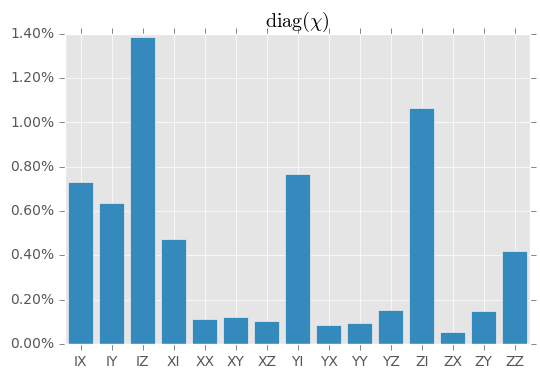

In [23]:
plt.bar(0.1 + np.arange(15), np.diag(qt.to_chi(S_qobj).unit().data.todense())[1:])
plt.xticks(0.5 + np.arange(15), list(map("".join, product('IXYZ', repeat=2)))[1:])
plt.xlim(0, 15)
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:0.2%}"))
plt.title(r"$\mathrm{diag}(\chi)$")

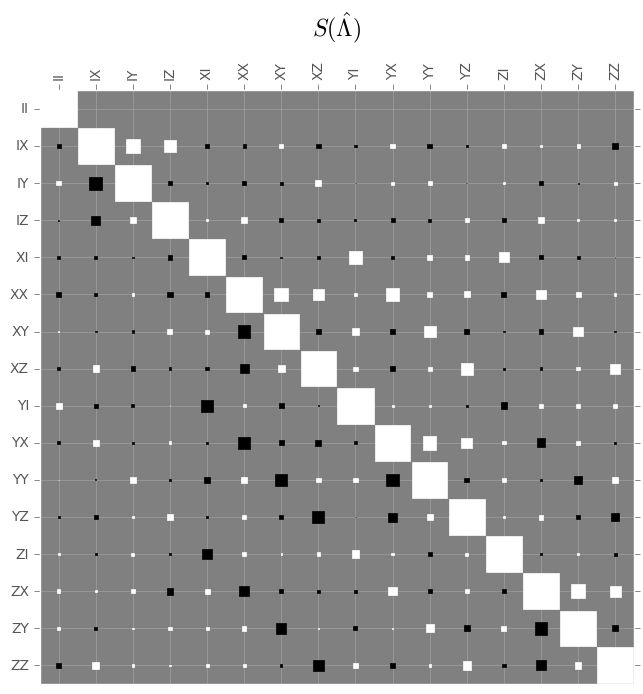

In [24]:
plt.figure(figsize=(7,) * 2)
# We manually plot the superoperator as a Hinton diagram
# so that we can customize its appearance better.
hinton(qt.superop_reps._super_to_superpauli(S_qobj).full())
plt.gca().xaxis.grid(True, color=u'#a0a0a0')
plt.gca().yaxis.grid(True, color=u'#a0a0a0')
plt.gca().xaxis.tick_top()
plt.xticks(np.arange(16), list(map("".join, product(u'IXYZ', repeat=2))), rotation='vertical');
plt.yticks(np.arange(16), list(map("".join, product(u'IXYZ', repeat=2))));
plt.title(r"$S(\hat{\Lambda})$", y=1.08, fontdict=dict(fontsize=17))
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.savefig('../fig/qpt-point-est-superpauli.pdf')

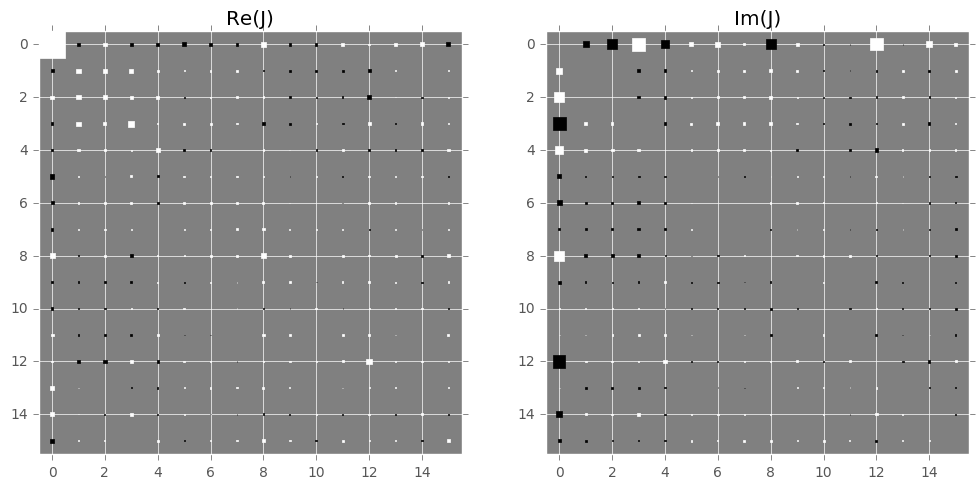

In [25]:
fig, (left, right) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
plt.sca(left)
hinton(qt.to_chi(J_qobj).data.real.toarray(), max_value=4)
plt.title('Re(J)')
plt.sca(right)
plt.title('Im(J)')
hinton(qt.to_chi(J_qobj).data.imag.toarray(), max_value=4)

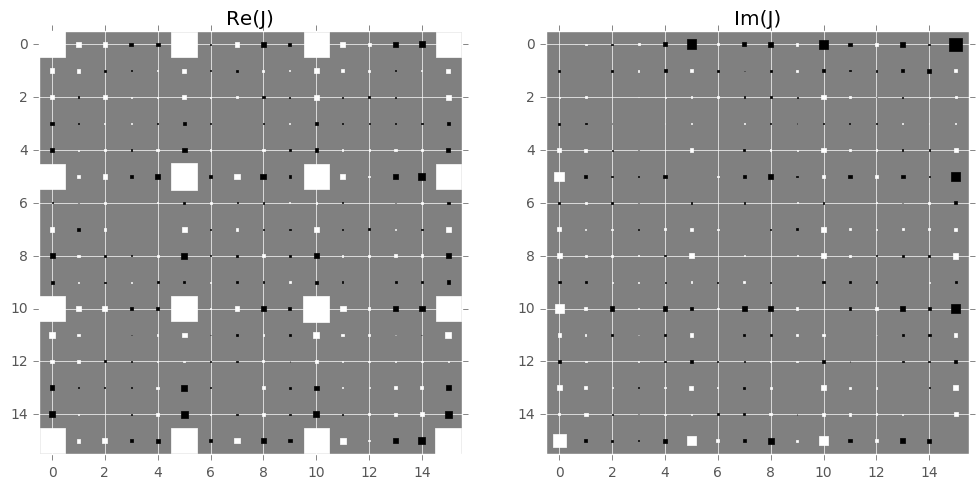

In [26]:
fig, (left, right) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
plt.sca(left)
hinton(J_qobj.data.real.toarray(), max_value=1)
plt.title('Re(J)')
plt.sca(right)
plt.title('Im(J)')
hinton(J_qobj.data.imag.toarray(), max_value=1)

In [27]:
S_qobj(qt.ket2dm(qt.tensor(qt.basis(2, 0), qt.basis(2, 0))))

Quantum object: dims = [[2, 2], [2, 2]], shape = [4, 4], type = oper, isherm = True
Qobj data =
[[ 0.95704822+0.j          0.03092180+0.00428494j  0.02762981-0.00271654j
  -0.01974209+0.00508866j]
 [ 0.03092180-0.00428494j  0.02106319+0.j         -0.00449976-0.00312609j
  -0.00137909+0.00394467j]
 [ 0.02762981+0.00271654j -0.00449976+0.00312609j  0.02019449+0.j
   0.00103504+0.00032672j]
 [-0.01974209-0.00508866j -0.00137909-0.00394467j  0.00103504-0.00032672j
   0.00169410+0.j        ]]

In [28]:
J_state = qt.Qobj(J_qobj, dims=[[2] * 4] * 2).unit()

In [29]:
J_state.ptrace((0, 1)) # TP

Quantum object: dims = [[2, 2], [2, 2]], shape = [4, 4], type = oper, isherm = True
Qobj data =
[[ 0.25  0.    0.    0.  ]
 [ 0.    0.25  0.    0.  ]
 [ 0.    0.    0.25  0.  ]
 [ 0.    0.    0.    0.25]]

In [30]:
J_state.ptrace((2, 3)) # Unital

Quantum object: dims = [[2, 2], [2, 2]], shape = [4, 4], type = oper, isherm = True
Qobj data =
[[ 0.24690653+0.j         -0.00094631+0.00496579j -0.00263013+0.00560868j
  -0.00354096-0.00129557j]
 [-0.00094631-0.00496579j  0.25421697+0.j         -0.00336927-0.00212237j
   0.00055547+0.0070642j ]
 [-0.00263013-0.00560868j -0.00336927+0.00212237j  0.25292644+0.j
  -0.00542987+0.00281036j]
 [-0.00354096+0.00129557j  0.00055547-0.0070642j  -0.00542987-0.00281036j
   0.24595006+0.j        ]]

## Extracting a 7-Qubit Error Model ##

We finish by using the tomographic estimate above to compute an example of a seven-qubit error model. In doing so, we first extract the Pauli channel portion of the estimated channel $\hat{\Lambda}$.

In [31]:
diag_chi = np.diag(qt.to_chi(J_qobj).data.toarray()).real.copy()

As a quick check, we compare the ⋄-norm of the Pauli-twirled and original channels.

In [32]:
chi_twirled = qt.Qobj(np.diag(qt.to_chi(J_qobj).diag()), superrep='chi', dims=J_qobj.dims)
chi_twirled

Quantum object: dims = [[[2, 2], [2, 2]], [[2, 2], [2, 2]]], shape = [16, 16], type = super, isherm = True, superrep = chi
Qobj data =
[[  1.49835978e+01   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   1.17141170e-01   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   1.02042919e-01   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0

That this difference is significant indicates that the Pauli-twirled approximation omits the effects of coherent errors such as indicated by the off-diagonal elements of the superoperator and $\chi$ representations of $\hat{\Lambda}$. We could in principle address this by more sophisticated approximations such as honest approximation, but we are mainly interested here in demonstrating our approach on a plausible channel. Thus, we will continue to use the Pauli-twirled approximation.

In any case, we compute the product of two Pauli channels by multiplying the diagonal entries of their respective superoperator representations. We thus need an efficient way of converting large channels ($4^7 \times 4^7 = 2^{28} \approx 17 \text{ GB}$) between superoperator and $\chi$-operator representations using only their diagonal entries ($4^7 = 2^{14} \approx 1 \text{MB}$). We note that, assuming that $S_{\alpha,\beta} = s_\alpha \delta_{\alpha,\beta}$ and $\chi_{\mu,\nu} = c_{\mu} \delta_{\mu,\nu}$ for vectors $\vec{s}$ and $\vec{c}$, we can convert between these vectors as
$$\begin{aligned}
    s_{\alpha} & = \sum_\mu C_{\alpha,\mu} c_{\mu} \\
    \text{where } C_{\alpha,\mu} & \defeq \begin{cases}
        1 / 4^n & [\sigma_\alpha, \sigma_\mu] = 0 \\
        -1 / 4^n & \{\sigma_\alpha, \sigma_\mu\} = 0
    \end{cases},
\end{aligned}$$
and where $n$ is the number of qubits on which $\Lambda$ acts. We compute this commutator matrix $C$ by using binary symplectic form. Though we could use QuaEC or similar to do so, we choose to implement binary symplectic form directly here so as to minimize dependencies.

We start by defining the Pauli group in binary symplectic form.

In [33]:
def pauli_bsv(nq):
    I, X, Y, Z = [
        (0, 0),
        (1, 0),
        (1, 1),
        (0, 1)
    ]
    
    arr = np.empty((4 ** nq, ), dtype=[('x', bool, (nq, )), ('z', bool, (nq, ))])
    
    for idx_pauli, (xs, zs) in enumerate(list(starmap(zip, product([I, X, Y, Z], repeat=nq)))):
        arr[idx_pauli] = (xs, zs)
       
    return arr

For example, in the binary symplectic representation, the Pauli group on two qubits consists of 16 pairs of bit strings, with each pair describing the $X$ and $Z$ factors of a Pauli operator.

In [34]:
for label, binary_symplectic_form in zip(map("".join, product('IXYZ', repeat=2)), pauli_bsv(2)):
    print("{0}: ( {1[x]} | {1[z]} )".format(label, binary_symplectic_form))

II: ( [False False] | [False False] )
IX: ( [False  True] | [False False] )
IY: ( [False  True] | [False  True] )
IZ: ( [False False] | [False  True] )
XI: ( [ True False] | [False False] )
XX: ( [ True  True] | [False False] )
XY: ( [ True  True] | [False  True] )
XZ: ( [ True False] | [False  True] )
YI: ( [ True False] | [ True False] )
YX: ( [ True  True] | [ True False] )
YY: ( [ True  True] | [ True  True] )
YZ: ( [ True False] | [ True  True] )
ZI: ( [False False] | [ True False] )
ZX: ( [False  True] | [ True False] )
ZY: ( [False  True] | [ True  True] )
ZZ: ( [False False] | [ True  True] )


This representation makes it easy to compute commutators by using the binary symplectic inner product $\vec{p} \odot \vec{q} = \vec{p}_x \cdot \vec{q}_z + \vec{p}_z \cdot \vec{q}_x$, where all arithmetic is carried out modulo 2. In NumPy, we implement $\vec{p}_x \cdot \vec{q}_z$  as reducing ``logical_xor`` over ``logical_and``, since XOR and AND correspond to addition and multiplication modulo 2.

In [35]:
def bs_inner_product(p, q):        
    return np.logical_xor(
        np.logical_xor.reduce(np.logical_and(p['x'], q['z']), axis=-1),
        np.logical_xor.reduce(np.logical_and(p['z'], q['x']), axis=-1)
    )

Using broadcasting, we can now efficiently compute the commutator matrix defined above.

In [36]:
@memoize
def commutator_matrix(nq, chi_to_S=True):
    dim = 2 ** nq 
    paulis = pauli_bsv(nq)
    
    C = (-1) ** bs_inner_product(
        paulis[:, None],
        paulis[None, :]
    )
    
    return C / dim ** 2 if chi_to_S else C

Critically, the commutator matrix is self-inverse up to normalization factors corresponding to the different conventions used in the superoperator and $\chi$-operator representations.

In [37]:
np.dot(commutator_matrix(1, True), commutator_matrix(1, False))

array([[ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.]])

Next, we use some tensor reshaping tricks to expand the diagonal of a superoperator to the diagonal of a larger superoperator. This will let us represent $\Lambda$ acting on a specific pair of qubits with the other qubits left unaffected.

In [38]:
def expand_pauli_channel(diag_S, nq, *indices):
    diag_S = diag_S.reshape(tuple([
        4 if idx_qubit in indices else 1
        for idx_qubit in range(nq)
    ]))
    
    new_array = np.zeros((4,) * nq)
    new_array[...] = diag_S
    
    return new_array.flatten()

Finally, we expand $\Lambda$ over adjacent pairs of qubits and multiply them together to obtain our final seven-qubit channel.

In [39]:
def product_channel(diag_chi, nq):
    diag_S = np.dot(commutator_matrix(2, True), diag_chi)
    
    return np.dot(commutator_matrix(nq, False), reduce(mul,
        [
            expand_pauli_channel(diag_S, nq, idx_qubit, idx_qubit + 1)
            for idx_qubit in range(nq - 1)
        ]
    ))

In [40]:
def convex_channel(diag_chi, nq):
    diag_S = np.dot(commutator_matrix(2, True), diag_chi)
    
    return np.dot(commutator_matrix(nq, False), np.mean(
        [
            expand_pauli_channel(diag_S, nq, idx_qubit, idx_qubit + 1)
            for idx_qubit in range(nq - 1)
        ],
        axis=0
    ))

In [41]:
def convex_product_channel(diag_chi, nq):
    diag_S = np.dot(commutator_matrix(2, True), diag_chi)
    assert (nq % 2 == 1), "Expected odd # of qubits, got even."
    
    return np.dot(commutator_matrix(nq, False), np.mean(
        [
            reduce(mul, [
                expand_pauli_channel(diag_S, nq, idx_qubit, idx_qubit + 1)
                for idx_qubit in range(offset, nq - 1, 2)
            ])
            for offset in range(2)
        ],
        axis=0
    ))

We normalize the diagonal of the resulting $\chi$ operator to obtain the probabilities for each Pauli operator in our combined channel.

In [42]:
def unit(arr):
    arr /= arr.sum()
    return arr

## Error Models for Other Tomography Data Sets ##

We conclude the notebook by repeating the above analysis for each different data set, saving the resulting Pauli channel probability tables into a MATLAB-formatted file. We choose to format as a MAT-file, as this is the simplest structured data format understood by both MATLAB and Python.

In [43]:
# Optionally load progress reporting using
# pyprind (Python Progress Indicator).
try:
    from pyprind import prog_bar
except:
    prog_bar = lambda iterator, **options: iterator

In [44]:
sorted({'a': 1, 'b': 2, 'c': 3}.items(), key=lambda item: item[0])

[('a', 1), ('b', 2), ('c', 3)]

In [45]:
all_tomographic_estimates = {
    data_set_name:

    solve_tomography_problem(
        population_data, norm=2, solve_options=dict(maxit=200, verbose=0), quiet=False
    )
    
    # Loop over all available data sets.
    for data_set_name, population_data
    # We optionally use a progress bar to monitor
    # how far through the iterator over data we
    # are.
    in prog_bar(
        list(sorted(
            loadmat('innsbruck-data.mat').items(),
            key=lambda item: item[0]
        )),
        monitor=True
    )
    if not data_set_name.startswith('__')
}

0%        100%
[            ]

Mean residual in Δ:	2.17%
Purity of J(Λ) / D:	89.98%
AGF F(Λ):		94.92%
Unitarity u(Λ):	89.30%


[##          ] | ETA: 00:08:53

Mean residual in Δ:	3.39%
Purity of J(Λ) / D:	27.15%
AGF F(Λ):		46.83%
Unitarity u(Λ):	22.17%


[###         ] | ETA: 00:08:00

Mean residual in Δ:	3.74%
Purity of J(Λ) / D:	59.67%
AGF F(Λ):		75.89%
Unitarity u(Λ):	56.74%
Mean residual in Δ:	3.14%
Purity of J(Λ) / D:	28.57%
AGF F(Λ):		46.03%
Unitarity u(Λ):	23.61%


[#####       ] | ETA: 00:06:12

Mean residual in Δ:	6.08%
Purity of J(Λ) / D:	39.19%
AGF F(Λ):		42.59%
Unitarity u(Λ):	34.81%


[######      ] | ETA: 00:05:19

Mean residual in Δ:	4.87%
Purity of J(Λ) / D:	29.97%
AGF F(Λ):		43.81%
Unitarity u(Λ):	25.21%
Mean residual in Δ:	5.88%
Purity of J(Λ) / D:	30.25%
AGF F(Λ):		47.96%
Unitarity u(Λ):	25.54%


[########    ] | ETA: 00:03:32

Mean residual in Δ:	4.90%
Purity of J(Λ) / D:	29.61%
AGF F(Λ):		45.63%
Unitarity u(Λ):	24.85%


[############] | ETA: 00:02:39 | ETA: 00:00:43 | ETA: 00:00:00 | ETA: 00:00:00

Mean residual in Δ:	3.78%
Purity of J(Λ) / D:	29.06%
AGF F(Λ):		45.27%
Unitarity u(Λ):	24.20%



Total time elapsed: 00:07:58


In [46]:
all_pauli_tables = dict(
    pauli_labels=list(map("".join, product('IXYZ', repeat=7))),
    **{
        # Assign the table of Pauli channel probabilities to a key
        # with the same name as the original data, but transformed to
        # a valid MATLAB field name.
        "pauli_table_{}_{}".format(
            data_set_name.replace(".txt", ""),
            extrapolation_fn.__name__
         ):

        # Expand χ as a pairwise channel acting on seven qubits.
        unit(extrapolation_fn(
            # J → χ.
            np.diag(qt.to_chi(
                J_est
            ).data.toarray()).real.copy(),
        7)) 

        # Loop over all available tomographic estimates.
        for data_set_name, J_est
        in prog_bar(
            list(sorted(
                all_tomographic_estimates.items(),
                key=lambda item: item[0]
            )),
            monitor=True
        )
        
        for extrapolation_fn in [
            convex_channel,
            product_channel,
            convex_product_channel
        ]
    }
)

0%     100%
[#########] | ETA: 00:00:58 | ETA: 00:00:36 | ETA: 00:00:24 | ETA: 00:00:17 | ETA: 00:00:11 | ETA: 00:00:06 | ETA: 00:00:03 | ETA: 00:00:00 | ETA: 00:00:00
Total time elapsed: 00:00:27


The line above gives us a dictionary with one field for each tomography data set and channel extrapolation method, plus one more field for the Pauli labels.

In [47]:
print(", ".join(sorted(all_pauli_tables.keys())))

pauli_labels, pauli_table_0_ms_convex_channel, pauli_table_0_ms_convex_product_channel, pauli_table_0_ms_product_channel, pauli_table_100_ms_convex_channel, pauli_table_100_ms_convex_product_channel, pauli_table_100_ms_product_channel, pauli_table_10_ms_convex_channel, pauli_table_10_ms_convex_product_channel, pauli_table_10_ms_product_channel, pauli_table_120_ms_convex_channel, pauli_table_120_ms_convex_product_channel, pauli_table_120_ms_product_channel, pauli_table_20_ms_convex_channel, pauli_table_20_ms_convex_product_channel, pauli_table_20_ms_product_channel, pauli_table_30_ms_convex_channel, pauli_table_30_ms_convex_product_channel, pauli_table_30_ms_product_channel, pauli_table_40_ms_convex_channel, pauli_table_40_ms_convex_product_channel, pauli_table_40_ms_product_channel, pauli_table_60_ms_convex_channel, pauli_table_60_ms_convex_product_channel, pauli_table_60_ms_product_channel, pauli_table_80_ms_convex_channel, pauli_table_80_ms_convex_product_channel, pauli_table_80_ms_p

Finally, we can export the 7-qubit channels extracted from each tomographic estimate to MATLAB using SciPy's ``savemat`` function.

In [48]:
savemat(
    'all_pauli_tables.mat',
    all_pauli_tables,
    
    # Recall that MAT-files do ★not★ support rank-1
    # tensors ("vectors"). Thus, we need to tell SciPy
    # to promote "vectors" to "column vectors"
    # (concretely, rank-2 tensors with a leftmost
    # singleton dimension).
    oned_as='column'
)

As a quick consistency check, we load the MAT file back and check that it looks as we would expect.

In [49]:
loadmat(
    'all_pauli_tables.mat',
    
    # Remove extraneous singleton dimensions introduced
    # by the MAT-file format.
    squeeze_me=True,
    
    # Turn MATLAB character arrays back into Python strings.
    chars_as_strings=True
)

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Fri Mar 17 19:55:57 2017',
 '__version__': '1.0',
 'pauli_labels': array(['IIIIIII', 'IIIIIIX', 'IIIIIIY', ..., 'ZZZZZZX', 'ZZZZZZY',
        'ZZZZZZZ'], 
       dtype='<U7'),
 'pauli_table_0_ms_convex_channel': array([  9.36514972e-01,   1.21772081e-03,   1.05628757e-03, ...,
         -2.71050543e-19,   3.52365706e-19,   2.43945489e-19]),
 'pauli_table_0_ms_convex_product_channel': array([  8.21380097e-01,   3.20404372e-03,   2.77928366e-03, ...,
          4.67562187e-19,   1.28749008e-19,   1.82959117e-19]),
 'pauli_table_0_ms_product_channel': array([  6.75555944e-01,   5.28570132e-03,   4.59845758e-03, ...,
          1.29778517e-09,   2.15459530e-09,   5.52138196e-09]),
 'pauli_table_100_ms_convex_channel': array([  3.35400219e-01,   2.48560654e-03,   3.47995834e-03, ...,
          4.70950319e-19,  -4.98055373e-19,   3.55753838e-19]),
 'pauli_table_100_ms_convex_product_channel': array([  3.773027